In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import torch as th
import torch.nn.functional as F
import numpy as np
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import talib as ta
import datetime
from Tools.util import progressbar

In [3]:
cd /home/andre/PycharmProjects/stocks

/home/andre/PycharmProjects/stocks


In [4]:
from Tools import Meta5_Ibov_Load as meta5load

In [5]:
meta5filepath='/home/andre/.wine/drive_c/Program Files/Rico MetaTrader 5/MQL5/Files'

In [6]:
meta5load.Set_Data_Path(meta5filepath, meta5filepath)

master data loaded size (minutes):  501003
Symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


In [7]:
masterdf = meta5load.Load_Meta5_Data(preload=False) # ignore preloaded dataframe force-reload

Symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
percentage of missing minute data  2.82%


todo in the near feature PETR4 change to IBOV miniindex

In [8]:
X = meta5load.FixedColumnNames()

In [9]:
len(X)

501003

In [10]:
# latest 3 months data for testing 

In [11]:
# X=X[-60*7*5*4*3:]

Simpler models are often more efficient.

## Simple binary classes
### Russian approach. Going up (above moving average) or down (bellow moving average).
### Slide 120 minutes behind (causality assumption)

In [12]:
def createTargetVector(X, targetsymbol, view=True):
    span=120 # best long trend guide until now
    X['ema'] = ta.EMA(X[targetsymbol].values, span)
    X.loc[ X[targetsymbol] > X.ema, 'y'] = 1
    X.loc[ X[targetsymbol] < X.ema, 'y'] = 0
    X.y = X.y.shift(-span) # has to be 120!!!
    if view:
        f, axr = plt.subplots(2, sharex=True, figsize=(15,4))
        f.subplots_adjust(hspace=0)
        axr[0].plot(X.ema.values[-1200:], label='ema120')
        axr[0].plot(X[targetsymbol].values[-1200:], label=targetsymbol)
        axr[0].legend()
        plt.figure(figsize=(10,3))
        axr[1].plot(X.y.values[-1200:], label='-120 minutes target class up/down : 1/0')
        axr[1].legend(loc='center')    
    y = X.y
    X.drop(['y','ema'], axis=1, inplace=True) 
    # those are the minutes that will be used for prediction    
    indexp = y[y.isnull()].index
    #y = y[~y.isnull()] # remove last 120 minutes
    return X, y, indexp

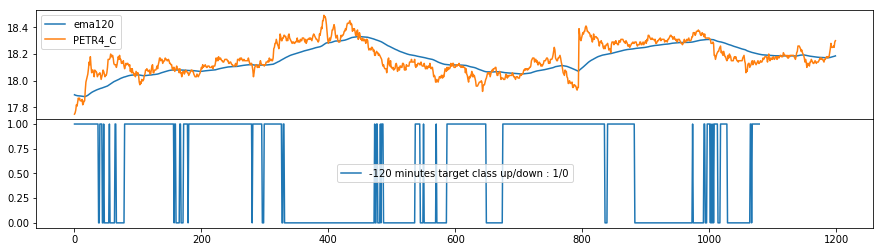

<Figure size 720x216 with 0 Axes>

In [13]:
X, y, indexp = createTargetVector(X, targetsymbol='PETR4_C')

In [14]:
y.unique() # dont need to change this now

array([ 1.,  0., nan])

# Prepare data for training

### Can only make Log of Volume Data 
  Tick Volume and Real Volume
  
Bucktize and clippng must be re-analysed to not use future information.

In [15]:
def LogVols(X):
    for col in X:
        # bucketize volumes and tick volume but before make log of them
        if col.endswith('R') or col.endswith('T'):
            X[col] = np.log(X[col].values+1.) # +1 to avoid log of 0

### Create Some Crossed Features

In [16]:
def createCrossedFeatures(df, span=60):
    """
    many indicators etc.
    note: all windows of moving averages are alligned to the right
    """ 
    def tofloat64(df): # talib needs this
        for col in df.columns:
            if df[col].dtype != np.float64:
                df.loc[:, col] = df.loc[:, col].values.astype(np.float64)
    tofloat64(df) # TALIB works only with real numbers (np.float64)
    # add two indicators hour and day of week
    df['hour'] = df.index.hour.astype(np.float64)
    df['weekday']  = df.index.dayofweek.astype(np.float64)
    df['minute'] = np.apply_along_axis(lambda x : np.float64(pd.to_datetime(x).minute), 
                                       arr=df.index.values, axis=0)
    quotes = df.columns
    for quote in quotes:
        df['ema_2'+quote] = ta.EMA(df[quote].values, span*2)      
        df['ema_3'+quote] = ta.EMA(df[quote].values, span*3)  
        df['dema_2'+quote] = df[quote] - df['ema_2'+quote]
        df['dema_3'+quote] = df[quote] - df['ema_3'+quote]
        df['macd'+quote] = ta.MACD(df[quote].values)[0]
        df['macd_mean'+quote] = ta.MACD(df[quote].values, span, span*2)[0]
        df['macd_double'+quote] = ta.MACD(df[quote].values, span, span*3)[0]
        df['rsi_2'+quote] = ta.RSI(df[quote].values, span*2)
        df['rsi_3'+quote] = ta.RSI(df[quote].values, span*3)
# don't have idea how to reproduce this independing on the order of the data read
# also can't find meaning on this, doesn't make much sense
#     for i in range(len(quotes)-1):
#         df[quotes[i]+'_+_'+quotes[i+1]] = df[quotes[i]]+df[quotes[i+1]]
    return df

In [17]:
LogVols(X)

In [18]:
X = createCrossedFeatures(X)

### Drop highly correlated series > 95%

In [19]:
def RemoveSimilarFeatures(X, correlation=95.):
    """
    remove features with more than 95% absolute correlation
    note : very slow for calculate on big data frames
    """
    correlation = X.corr()
    corr_matrix = correlation.abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    # Drop features
    X.drop(to_drop, axis=1, inplace=True)
    return X

### Save/Read collumn names to avoid recalculanting correlation above

In [20]:
cd /home/andre/PycharmProjects/stocks/data/

/home/andre/PycharmProjects/stocks/data


In [21]:
# with open('collumns_selected.txt', 'wt') as f:
#     f.write(np.sum(X.columns.values+[' ']))

In [22]:
with open('collumns_selected.txt', 'r') as f:
    collumns = f.read()

In [23]:
select_collumns = collumns.split(' ')[:-1]

In [24]:
len(select_collumns)

148

In [25]:
X = X[select_collumns]

### to thing about?!

"Selected collumns" not using ema3 180 minutes...

In [26]:
len(X[X.isnull().any(axis=1)])
#X[X.isnull().any(axis=1)].tail(2)
#X[X.isnull().any(axis=1)].head(2)

127

## Standardize Variance and Mean

Another transformations in here
http://scikit-learn.org/stable/modules/preprocessing.html

**drop nan values due moving averages and indicators etc...**  

The first 3*span samples is (More) maximum number of nans on the beginning? Macd/RSI need to read about talib.

Since we cannot use information from the future  
the Scaler will be allways applied with the same variance and mean.  
Those will be considered constante based on the last information we have  
500k minutes ~ 5 years from 2013++  
Those are saved on the files `stock_stats_2018.csv`
That is almost equivalent of using the Standard Scaler with the entire data.  
Based on the tests so far I intepret the most import characteristics is having var < 1 and mean close to 0.  
This has the needed feature of being able to be used on real-time new data.

In [1]:
# stats = X.describe()
# stats = stats.transpose()
# stocks_stats = stats[['mean', 'std']]
# stocks_stats.head()
#stocks_stats.to_csv('stocks_stats_2018.csv')

In [28]:
stocks_stats = pd.read_csv('stocks_stats_2018.csv', index_col=0)

In [29]:
stocks_stats.head()

,mean,std
BBAS3_O,23.728781,7.149573
BBAS3_T,3.562130,0.776066
BBAS3_R,9.180201,1.146551
DOL$_O,3689.199145,467.782163
DOL$_T,4.115324,1.233165


In [30]:
def ScaleNormalize(X, stats):
    """given mean and variance (stats dataframe)
    for each collum `convert` to variance 1 and mean 0
    subtract mean and divide by variance"""
    for col in X: # make variance 1 and mean 0
        X[col] = (X[col]-stats.loc[col, 'mean'])/stats.loc[col, 'std']

In [31]:
X.dropna(inplace=True) # nans from emas etcs...

In [32]:
ScaleNormalize(X, stocks_stats)

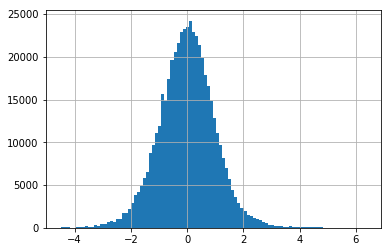

In [33]:
X.ITUB4_R.hist(bins=100)

In [44]:
X['ITUB4_R'].std() # variance 1

1.0001143142528615

In [45]:
X['ITUB4_R'].mean() # mean zero

2.700179176599341e-06

### Prepare and Align Final Vectors

Training: X, y 
Prediction: Xp (last 120 minutes for prediction)

In [36]:
Xp = X.loc[indexp] ## for prediction get the last

In [37]:
X.drop(Xp.index, inplace=True) ## for training remove last 120 minutes for prediction

In [38]:
y = y[X.index] ## update training vector, this already removes the last 120 nan values

In [39]:
len(X)

500756

In [40]:
len(y)

500756

In [41]:
len(Xp)

120

In [42]:
X.to_pickle('X_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')

In [43]:
y.to_pickle('Y_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')